**Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 19 Nov (Testing Multivariate)**



1. Test on all Monday 24 hours data for Connector SB L_1 & Juniper WB L_1

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check
print (dataset.iloc[49]['State-EB-L_1'])
print (dataset.iloc[3359]['State-EB-L_1'])

-10.0
7.0


[42. 42. 50. ... 28. 18. 22.]
[[12. 42.]
 [10. 42.]
 [ 6. 50.]
 ...
 [ 6. 28.]
 [ 5. 18.]
 [ 4. 22.]]


(-17.75, 150)

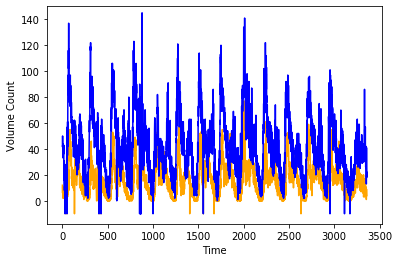

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Connector-SB-L_1'].values
series_output = dataset['Connector-SB-L_1'].values
print (series_output)
series_inputs = dataset[['Juniper-WB-L_1','Connector-SB-L_1']].values
print (series_inputs)
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
#plot_series(time_num, series)
# plot_series(time_num, series_inputs[:,0])
# plot_series(time_num, series_inputs[:,1])

plt.plot(time_num, series_inputs[:,0], color='orange')
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-14.350000000000001, 150)

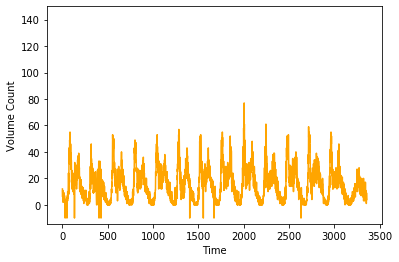

In [5]:
plt.plot(time_num, series_inputs[:,0], color='orange')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

(-17.75, 150)

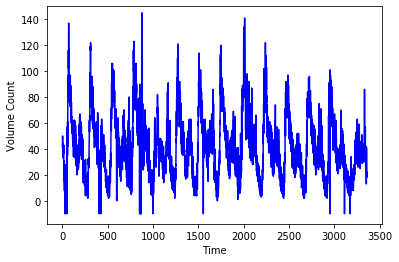

In [6]:
plt.plot(time_num, series_inputs[:,1], color='blue')
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.ylim(top=150)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [7]:
num_days = 11
split_time = num_days*240
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

time_train = time[:split_time]
x_train = series_inputs[:split_time]
time_valid = time[split_time:]
x_valid = series_inputs[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [ ]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = series.astype(np.float64)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
    dataset = dataset.batch(batch_size).prefetch(1)
#     print (dataset)
#     for window in dataset:
#         print (window[0].shape)
    return dataset
# for window in dataset:
#     print (window)
    #dataset = dataset.map(lambda window: (window[:-1], window[-1][1]))
#dataset = dataset.map(lambda window: (window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
    #print (window.numpy()[1])
    #dataset = dataset.batch(batch_size).prefetch(1)
    #print (dataset)
    #return dataset
# for window in dataset:
#     print (window[0].numpy())
#     print (window[1].numpy())
    #return dataset
# dataset = tf.data.Dataset.from_tensor_slices(series_output)
# # print (dataset)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

# dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
# print (dataset)

# print (dataset)
# dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
# dataset = dataset.batch(batch_size).prefetch(1)
  #return dataset


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(series_inputs)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1][1]))
dataset = dataset.batch(batch_size).prefetch(3)
print (dataset)
for window in dataset:
    print (window[0].shape)

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#y = tf.cast(y, tf.float32)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print (dataset)
#dataset = tf.cast(dataset, tf.float64)

model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=None),
    #tf.keras.layers.Lambda(lambda x:tf.cast(x, tf.float64)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])


In [ ]:
for window in dataset:
    print (window[0].numpy())
    print (window[1].numpy())

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(batch_size, window_size,2))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),

  tf.keras.layers.Lambda(lambda x: x*100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('connector_sb_l1.h5')

In [8]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('connector_sb_l1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  8960      
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  33600     
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  38720     
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  28928     
_________________________________________________________________
dense (Dense)                multiple                  65        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 110,273
Trainable params: 110,273
Non-trainable params: 0
__________________________________________________

(-15.55, 120)

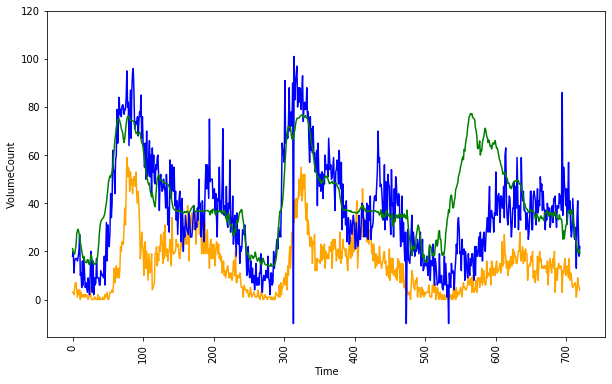

In [9]:
forecast = []
results = []
for time in range(len(series_inputs) - window_size):
    forecast.append(new_model.predict(series_inputs[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
time_valid = [i for i in range(len(time_valid))]
plt.plot(time_valid, x_valid[:,0], color='orange')
plt.plot(time_valid, x_valid[:,1], color='blue')
plt.plot(time_valid, results, color='green')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)

In [ ]:

forecast = []
results = []
for time in range(len(series_inputs) - window_size):
    forecast.append(new_model.predict(series_inputs[time:time + window_size][np.newaxis]))
    #print (series_inputs[time:time + window_size])
#start_window = series_inputs[0:0 + window_size][:,1]
#print (start_window)
#print (np.array(forecast)[:, 0, 0])
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
#results = np.concatenate((start_window, (np.array(forecast)[:, 0, 0])))

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
time_valid = [i for i in range(len(time_valid))]
plt.plot(time_valid, x_valid[:,0], color='orange')
plt.plot(time_valid, x_valid[:,1], color='blue')
plt.plot(time_valid, results, color='green')
plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.grid(False)
plt.ylim(top=120)
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
#
#forecast = forecast[split_time-window_size:]
#results = np.array(forecast)[:, 0, 0]

# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)
# time_valid = [i for i in range(len(series_inputs))]
# plt.plot(time_valid, series_inputs[:,0], color='orange')
# plt.plot(time_valid, series_inputs[:,1], color='blue')
# plt.plot(time_valid, results, color='green')
# plt.xlabel("Time")
# plt.ylabel("VolumeCount")
# plt.grid(False)
# plt.ylim(top=120)

In [ ]:
print (series_inputs[0:0 + window_size])
print (series_inputs[0:0 + window_size][:,1])

In [ ]:
p = np.array(forecast)[:, 0, 0]
q = np.array([1,2,3])
r = np.concatenate((p,q))
print (r)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()

11.733084

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], results).numpy()

26.877596

In [12]:
mae = tf.keras.metrics.mean_absolute_error(x_valid[:,1], results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid[:,1], results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid[:,1] - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 11.733084
mean squared error: 288.5845
root mean squared error: 16.987775109584778
forecast_bias: -3297.1010341644287
standard dev of errors: 16.358926434369902


## Forecast for Typical Days

In [13]:
typical_actuals = x_valid[:,1][:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 8.666585
mean squared error: 130.0081
root mean squared error: 11.402109559945133
forecast_bias: -124.64043426513672
standard dev of errors: 11.399152920593473


(-15.55, 120)

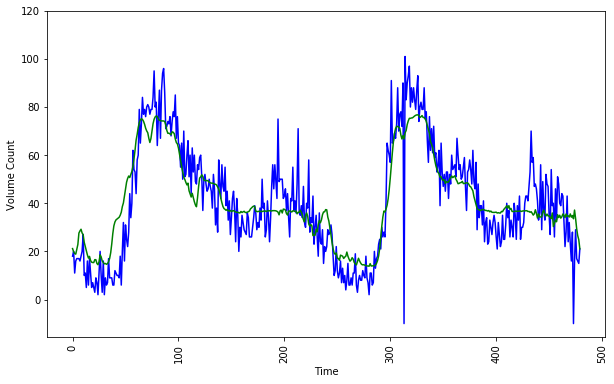

In [14]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast for Atypical Days

In [15]:
atypical_actuals = x_valid[:,1][-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 17.866085
mean squared error: 605.73737
root mean squared error: 24.611732277973775
forecast_bias: -3172.460599899292
standard dev of errors: 20.760692168179755


(-14.8, 120)

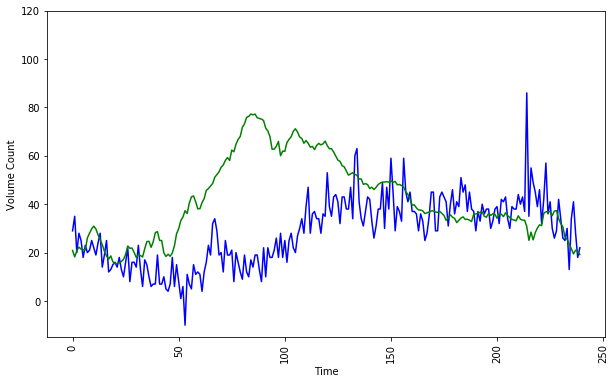

In [16]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

[[ 15.  46.]
 [ 20.  57.]
 [ 17.  29.]
 [ 25.  48.]
 [ 22.  34.]
 [ 21.  39.]
 [ 21.  39.]
 [ 18.  31.]
 [ 21.  41.]
 [ 15.  24.]
 [ 12.  32.]
 [ 18.  34.]
 [ 22.  23.]
 [ 26.  24.]
 [ 17.  33.]
 [ 26.  30.]
 [ 18.  27.]
 [ 19.  32.]
 [ 29.  35.]
 [ 20.  32.]
 [ 30.  26.]
 [ 25.  21.]
 [ 35.  32.]
 [ 41.  27.]
 [ 13.  22.]
 [ 20.  24.]
 [ 26.  35.]
 [ 26.  25.]
 [ 26.  25.]
 [ 28.  31.]
 [ 26.  40.]
 [ 46.  34.]
 [ 28.  37.]
 [ 34.  26.]
 [ 32.  33.]
 [ 32.  30.]
 [ 27.  26.]
 [ 24.  40.]
 [ 25.  35.]
 [ 24.  25.]
 [ 23.  39.]
 [ 29.  33.]
 [ 29.  43.]
 [ 27.  25.]
 [ 19.  30.]
 [ 23.  30.]
 [ 16.  32.]
 [ 23.  40.]
 [ 18.  43.]
 [ 13.  43.]
 [ 19.  41.]
 [ 14.  47.]
 [ 18.  53.]
 [ 17.  70.]
 [ 15.  57.]
 [ 22.  59.]
 [ 17.  47.]
 [ 15.  48.]
 [ 13.  46.]
 [ 15.  41.]
 [ 16.  33.]
 [ 19.  36.]
 [ 20.  56.]
 [ 15.  29.]
 [ 16.  49.]
 [ 10.  37.]
 [ 13.  33.]
 [ 14.  52.]
 [  9.  48.]
 [ 21.  47.]
 [  8.  35.]
 [ 17.  27.]
 [ 17.  54.]
 [ 11.  39.]
 [ 17.  40.]
 [ 10.  26.]
 [ 12.  46.]

[[4.0, 22.065401]]
[[ 21.          39.        ]
 [ 18.          31.        ]
 [ 21.          41.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [ 18.          34.        ]
 [ 22.          23.        ]
 [ 26.          24.        ]
 [ 17.          33.        ]
 [ 26.          30.        ]
 [ 18.          27.        ]
 [ 19.          32.        ]
 [ 29.          35.        ]
 [ 20.          32.        ]
 [ 30.          26.        ]
 [ 25.          21.        ]
 [ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.     

[[9.0, 27.009348]]
[[ 15.          24.        ]
 [ 12.          32.        ]
 [ 18.          34.        ]
 [ 22.          23.        ]
 [ 26.          24.        ]
 [ 17.          33.        ]
 [ 26.          30.        ]
 [ 18.          27.        ]
 [ 19.          32.        ]
 [ 29.          35.        ]
 [ 20.          32.        ]
 [ 30.          26.        ]
 [ 25.          21.        ]
 [ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.     

 [  4.          27.362463  ]]
[[5.0, 25.167612]]
[[ 26.          24.        ]
 [ 17.          33.        ]
 [ 26.          30.        ]
 [ 18.          27.        ]
 [ 19.          32.        ]
 [ 29.          35.        ]
 [ 20.          32.        ]
 [ 30.          26.        ]
 [ 25.          21.        ]
 [ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.    

[[5.0, 19.716232]]
[[ 18.          27.        ]
 [ 19.          32.        ]
 [ 29.          35.        ]
 [ 20.          32.        ]
 [ 30.          26.        ]
 [ 25.          21.        ]
 [ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.     

[[1.0, 16.45077]]
[[ 20.          32.        ]
 [ 30.          26.        ]
 [ 25.          21.        ]
 [ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.      

[[3.0, 15.635952]]
[[ 35.          32.        ]
 [ 41.          27.        ]
 [ 13.          22.        ]
 [ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.     

[[3.0, 17.490917]]
[[ 20.          24.        ]
 [ 26.          35.        ]
 [ 26.          25.        ]
 [ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.     

[[1.0, 21.271505]]
[[ 26.          25.        ]
 [ 28.          31.        ]
 [ 26.          40.        ]
 [ 46.          34.        ]
 [ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.     

[[6.0, 19.356298]]
[[ 28.          37.        ]
 [ 34.          26.        ]
 [ 32.          33.        ]
 [ 32.          30.        ]
 [ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.     

[[0.0, 22.105507]]
[[ 27.          26.        ]
 [ 24.          40.        ]
 [ 25.          35.        ]
 [ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.     

[[4.0, 19.85833]]
[[ 24.          25.        ]
 [ 23.          39.        ]
 [ 29.          33.        ]
 [ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.      

[[3.0, 18.88272]]
[[ 29.          43.        ]
 [ 27.          25.        ]
 [ 19.          30.        ]
 [ 23.          30.        ]
 [ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.      

[[0.0, 16.869888]]
[[ 16.          32.        ]
 [ 23.          40.        ]
 [ 18.          43.        ]
 [ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.     

[[ 13.          43.        ]
 [ 19.          41.        ]
 [ 14.          47.        ]
 [ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.        

[[1.0, 32.968185]]
[[ 18.          53.        ]
 [ 17.          70.        ]
 [ 15.          57.        ]
 [ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.     

[[2.0, 36.121]]
[[ 22.          59.        ]
 [ 17.          47.        ]
 [ 15.          48.        ]
 [ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        

[[0.0, 38.32463]]
[[ 13.          46.        ]
 [ 15.          41.        ]
 [ 16.          33.        ]
 [ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.      

[[5.0, 38.108738]]
[[ 19.          36.        ]
 [ 20.          56.        ]
 [ 15.          29.        ]
 [ 16.          49.        ]
 [ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.     

[[5.0, 49.87777]]
[[ 10.          37.        ]
 [ 13.          33.        ]
 [ 14.          52.        ]
 [  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.      

[[3.0, 55.38133]]
[[  9.          48.        ]
 [ 21.          47.        ]
 [  8.          35.        ]
 [ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.178426

[[5.0, 62.197006]]
[[ 17.          27.        ]
 [ 17.          54.        ]
 [ 11.          39.        ]
 [ 17.          40.        ]
 [ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176

[[7.0, 70.2726]]
[[ 10.          26.        ]
 [ 12.          46.        ]
 [ 12.          33.        ]
 [  9.          51.        ]
 [ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.0093479

 [  4.          69.54724121]]
[[4.0, 68.97694]]
[[ 13.          48.        ]
 [  8.          40.        ]
 [ 17.          39.        ]
 [ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.00934792]
 [  1.          31.13622284]
 [  5.          29.04861832]
 [  4.          27.36246

[[10.0, 65.13394]]
[[ 13.          44.        ]
 [ 16.          43.        ]
 [  7.          32.        ]
 [ 15.          22.        ]
 [  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.00934792]
 [  1.          31.13622284]
 [  5.          29.04861832]
 [  4.          27.362463  ]
 [  5.          25.16761208]
 [  1.          23.56829071]
 [  1.          21.9515419 ]
 [  5.          19.71623

[[9.0, 65.16647]]
[[  7.          28.        ]
 [  7.          43.        ]
 [ 15.          24.        ]
 [ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.00934792]
 [  1.          31.13622284]
 [  5.          29.04861832]
 [  4.          27.362463  ]
 [  5.          25.16761208]
 [  1.          23.56829071]
 [  1.          21.9515419 ]
 [  5.          19.7162323 ]
 [  2.          18.03266335]
 [  4.          16.92592812]
 [  1.          16.45076942]
 [  3.          16.246677

[[7.0, 67.55094]]
[[ 12.          32.        ]
 [  5.          23.        ]
 [  8.          16.        ]
 [  4.          28.        ]
 [ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.00934792]
 [  1.          31.13622284]
 [  5.          29.04861832]
 [  4.          27.362463  ]
 [  5.          25.16761208]
 [  1.          23.56829071]
 [  1.          21.9515419 ]
 [  5.          19.7162323 ]
 [  2.          18.03266335]
 [  4.          16.92592812]
 [  1.          16.45076942]
 [  3.          16.2466774 ]
 [  2.          15.57958412]
 [  3.          15.635952  ]
 [  3.          15.982111

[[8.0, 66.29509]]
[[ 10.         -10.        ]
 [  5.          16.        ]
 [  2.          29.        ]
 [  2.          17.        ]
 [  3.          16.        ]
 [  3.          15.        ]
 [  0.          21.        ]
 [  6.          20.90506554]
 [ 12.          18.17842674]
 [ 10.          20.00911331]
 [  7.          22.72230911]
 [  5.          24.56176376]
 [  4.          22.06540108]
 [  8.          21.98391533]
 [  7.          26.8522892 ]
 [  9.          27.00934792]
 [  1.          31.13622284]
 [  5.          29.04861832]
 [  4.          27.362463  ]
 [  5.          25.16761208]
 [  1.          23.56829071]
 [  1.          21.9515419 ]
 [  5.          19.7162323 ]
 [  2.          18.03266335]
 [  4.          16.92592812]
 [  1.          16.45076942]
 [  3.          16.2466774 ]
 [  2.          15.57958412]
 [  3.          15.635952  ]
 [  3.          15.98211193]
 [  3.          16.56132698]
 [  3.          17.49091721]
 [  6.          18.48376656]
 [  2.          22.856500

[[8.0, 62.840904]]
[[ 2.         17.        ]
 [ 3.         16.        ]
 [ 3.         15.        ]
 [ 0.         21.        ]
 [ 6.         20.90506554]
 [12.         18.17842674]
 [10.         20.00911331]
 [ 7.         22.72230911]
 [ 5.         24.56176376]
 [ 4.         22.06540108]
 [ 8.         21.98391533]
 [ 7.         26.8522892 ]
 [ 9.         27.00934792]
 [ 1.         31.13622284]
 [ 5.         29.04861832]
 [ 4.         27.362463  ]
 [ 5.         25.16761208]
 [ 1.         23.56829071]
 [ 1.         21.9515419 ]
 [ 5.         19.7162323 ]
 [ 2.         18.03266335]
 [ 4.         16.92592812]
 [ 1.         16.45076942]
 [ 3.         16.2466774 ]
 [ 2.         15.57958412]
 [ 3.         15.635952  ]
 [ 3.         15.98211193]
 [ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.    

[[6.0, 62.145454]]
[[10.         20.00911331]
 [ 7.         22.72230911]
 [ 5.         24.56176376]
 [ 4.         22.06540108]
 [ 8.         21.98391533]
 [ 7.         26.8522892 ]
 [ 9.         27.00934792]
 [ 1.         31.13622284]
 [ 5.         29.04861832]
 [ 4.         27.362463  ]
 [ 5.         25.16761208]
 [ 1.         23.56829071]
 [ 1.         21.9515419 ]
 [ 5.         19.7162323 ]
 [ 2.         18.03266335]
 [ 4.         16.92592812]
 [ 1.         16.45076942]
 [ 3.         16.2466774 ]
 [ 2.         15.57958412]
 [ 3.         15.635952  ]
 [ 3.         15.98211193]
 [ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.    

[[16.0, 59.96775]]
[[ 9.         27.00934792]
 [ 1.         31.13622284]
 [ 5.         29.04861832]
 [ 4.         27.362463  ]
 [ 5.         25.16761208]
 [ 1.         23.56829071]
 [ 1.         21.9515419 ]
 [ 5.         19.7162323 ]
 [ 2.         18.03266335]
 [ 4.         16.92592812]
 [ 1.         16.45076942]
 [ 3.         16.2466774 ]
 [ 2.         15.57958412]
 [ 3.         15.635952  ]
 [ 3.         15.98211193]
 [ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.    

[[10.0, 58.092255]]
[[ 5.         25.16761208]
 [ 1.         23.56829071]
 [ 1.         21.9515419 ]
 [ 5.         19.7162323 ]
 [ 2.         18.03266335]
 [ 4.         16.92592812]
 [ 1.         16.45076942]
 [ 3.         16.2466774 ]
 [ 2.         15.57958412]
 [ 3.         15.635952  ]
 [ 3.         15.98211193]
 [ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.   

[[15.0, 57.09131]]
[[ 2.         18.03266335]
 [ 4.         16.92592812]
 [ 1.         16.45076942]
 [ 3.         16.2466774 ]
 [ 2.         15.57958412]
 [ 3.         15.635952  ]
 [ 3.         15.98211193]
 [ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.    

[[11.0, 59.28585]]
[[ 3.         16.56132698]
 [ 3.         17.49091721]
 [ 6.         18.48376656]
 [ 2.         22.85650063]
 [ 1.         21.27150536]
 [ 1.         22.22487068]
 [ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.    

[[13.0, 57.13819]]
[[ 1.         20.61611176]
 [ 6.         18.51403809]
 [ 6.         19.35629845]
 [ 3.         18.41346359]
 [ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.    

[[27.0, 62.428932]]
[[ 3.         16.90149879]
 [ 7.         17.54102325]
 [ 0.         22.1055069 ]
 [ 2.         22.6335144 ]
 [ 5.         20.36115265]
 [ 4.         19.85832977]
 [ 0.         19.88472366]
 [ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.   

 [12.         59.40940857]]
[[16.0, 57.332794]]
[[ 1.         20.10778236]
 [ 3.         18.88272095]
 [ 1.         17.73221779]
 [ 0.         17.41108513]
 [ 2.         17.10727882]
 [ 0.         16.86988831]
 [ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.  

[[15.0, 58.757347]]
[[ 0.         17.78326035]
 [ 2.         19.25285149]
 [ 0.         21.89732742]
 [ 0.         26.9725647 ]
 [ 2.         29.23994637]
 [ 1.         32.96818542]
 [ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.   

[[18.0, 61.567646]]
[[ 2.         33.77297974]
 [ 0.         35.63596725]
 [ 2.         36.12099838]
 [ 2.         35.08358765]
 [ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.   

[[18.0, 51.427193]]
[[ 1.         36.26256561]
 [ 0.         38.32463074]
 [ 2.         38.15151978]
 [ 0.         36.8841629 ]
 [ 5.         38.10873795]
 [ 1.         39.88310623]
 [ 4.         42.55965424]
 [ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.   

[[21.0, 49.32191]]
[[ 0.         46.17647552]
 [ 5.         49.87776947]
 [ 1.         51.56632614]
 [ 3.         52.90741348]
 [ 3.         55.38132858]
 [ 2.         56.89016724]
 [ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.    

[[15.0, 41.873558]]
[[ 4.         58.83914948]
 [ 5.         62.19700623]
 [ 3.         64.78017426]
 [ 1.         68.23364258]
 [ 5.         70.53798676]
 [ 7.         70.27259827]
 [ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.   

[[12.0, 37.723392]]
[[ 5.         70.32797241]
 [ 5.         70.45762634]
 [ 4.         69.54724121]
 [ 4.         68.97693634]
 [ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.   

[[11.0, 34.44123]]
[[ 5.         67.93384552]
 [ 6.         66.606987  ]
 [10.         65.13394165]
 [ 7.         65.24848938]
 [ 6.         64.3861618 ]
 [ 8.         65.13376617]
 [ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.    

[[17.0, 36.10264]]
[[ 9.         65.16647339]
 [ 3.         66.57304382]
 [10.         67.13244629]
 [ 7.         67.55094147]
 [ 3.         68.2354126 ]
 [ 4.         68.42018127]
 [ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.    

[[13.0, 37.21754]]
[[ 4.         67.633461  ]
 [ 8.         66.29508972]
 [ 3.         64.60966492]
 [ 9.         63.00627136]
 [ 8.         62.84090424]
 [ 9.         62.6124382 ]
 [ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.    

[[16.0, 35.457333]]
[[ 5.         62.47738647]
 [ 9.         62.19629669]
 [ 7.         62.22473907]
 [13.         63.14056015]
 [ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.   

[[15.0, 35.86634]]
[[ 6.         62.14545441]
 [ 9.         60.20368195]
 [12.         59.6563797 ]
 [ 7.         60.24765778]
 [ 6.         60.73719406]
 [ 6.         60.55008316]
 [16.         59.96775055]
 [ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.    

 [13.         34.17352295]]
[[8.0, 35.094826]]
[[ 9.         59.2104187 ]
 [11.         58.73726654]
 [11.         58.84204102]
 [10.         58.09225464]
 [13.         57.26564407]
 [ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.   

[[14.0, 36.21796]]
[[ 6.         56.70258331]
 [16.         56.63902283]
 [15.         57.09130859]
 [10.         57.05512619]
 [13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.         55.76246262]
 [21.         54.65819931]
 [15.         58.75734711]
 [20.         60.32970428]
 [18.         64.08810425]
 [18.         64.21224213]
 [15.    

 [12.         34.8915863 ]]
[[11.0, 35.062996]]
[[13.         57.31848526]
 [12.         57.50213242]
 [10.         58.43915176]
 [14.         58.72889328]
 [16.         59.17995071]
 [11.         59.28585052]
 [12.         59.21622467]
 [12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.         55.76246262]
 [21.         54.65819931]
 [15.         58.75734711]
 [20.         60.32970428]
 [18.         64.08810425]
 [18.         64.21224213]
 [15.         63.85260391]
 [15.         63.08001709]
 [18.         61.56764603]
 [20.  

[[9.0, 34.11008]]
[[12.         58.96405029]
 [14.         58.39144135]
 [15.         57.78479767]
 [11.         57.28084946]
 [13.         57.13819122]
 [24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.         55.76246262]
 [21.         54.65819931]
 [15.         58.75734711]
 [20.         60.32970428]
 [18.         64.08810425]
 [18.         64.21224213]
 [15.         63.85260391]
 [15.         63.08001709]
 [18.         61.56764603]
 [20.         60.62509918]
 [20.         59.13837433]
 [28.         56.42884445]
 [18.         51.42719269]
 [16.         48.367836  ]
 [19.         48.28533936]
 [22.         48.69257355]
 [15.         48.63620377]
 [20.     

[[6.0, 33.5013]]
[[24.         57.25701904]
 [14.         61.79798126]
 [15.         62.33379364]
 [27.         62.42893219]
 [19.         64.69726562]
 [18.         64.08485413]
 [13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.         55.76246262]
 [21.         54.65819931]
 [15.         58.75734711]
 [20.         60.32970428]
 [18.         64.08810425]
 [18.         64.21224213]
 [15.         63.85260391]
 [15.         63.08001709]
 [18.         61.56764603]
 [20.         60.62509918]
 [20.         59.13837433]
 [28.         56.42884445]
 [18.         51.42719269]
 [16.         48.367836  ]
 [19.         48.28533936]
 [22.         48.69257355]
 [15.         48.63620377]
 [20.         49.34238052]
 [16.         48.58055115]
 [21.         49.32191086]
 [19.         48.60723495]
 [19.         49.05097961]
 [ 8.      

[[1.0, 20.884005]]
[[13.         63.03478622]
 [16.         62.61325073]
 [10.         61.25077438]
 [12.         59.40940857]
 [16.         57.33279419]
 [13.         55.80104065]
 [18.         54.48166275]
 [14.         56.87799454]
 [14.         55.76246262]
 [21.         54.65819931]
 [15.         58.75734711]
 [20.         60.32970428]
 [18.         64.08810425]
 [18.         64.21224213]
 [15.         63.85260391]
 [15.         63.08001709]
 [18.         61.56764603]
 [20.         60.62509918]
 [20.         59.13837433]
 [28.         56.42884445]
 [18.         51.42719269]
 [16.         48.367836  ]
 [19.         48.28533936]
 [22.         48.69257355]
 [15.         48.63620377]
 [20.         49.34238052]
 [16.         48.58055115]
 [21.         49.32191086]
 [19.         48.60723495]
 [19.         49.05097961]
 [ 8.         48.22269821]
 [13.         45.4926033 ]
 [14.         43.1459198 ]
 [15.         41.87355804]
 [14.         39.71696854]
 [18.         38.90100861]
 [16.    

(-15.55, 150)

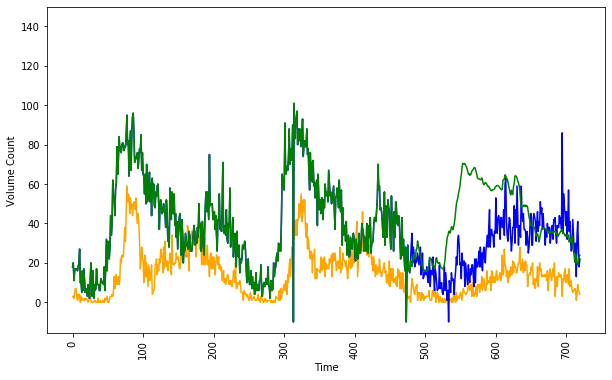

In [17]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 240
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
    print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
sliced_val_times = time_valid[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

#print (sliced_val_series)
# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series[:,1])
#print (sliced_val_series[:,1].shape)

In [18]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()

5.954461718930139

In [19]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,0], sliced_val_series[:,1]).numpy()

27.417945733335284

In [20]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 5.954461718930139
mean squared error: 189.66755568481895
root mean squared error: 13.771984449774076
forecast_bias: -3335.920928001404
standard dev of errors: 12.969224941409882


In [21]:
actuals = sliced_val_actual[:,1][-240:]
print (actuals)
predictions = sliced_val_series[:,1][-240:]
print (predictions)

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

[ 29.  35.  20.  28.  25.  18.  23.  20.  21.  25.  22.  19.  24.  28.
  14.  19.  25.  12.  13.  15.  16.  14.  18.  13.  10.  16.  22.   8.
  16.  16.  14.  23.  13.   6.  17.  15.  10.   6.   7.   7.  19.   7.
   7.  10.   5.   4.   7.  18.   6.  15.   8.   1.   6. -10.  11.   7.
   5.  15.  11.  12.  11.   4.  12.  16.  23.  19.  32.  34.  29.  19.
  20.  12.  25.  19.  19.  21.   8.  20.  16.  12.   9.  19.  12.  10.
  17.  14.  19.  19.  13.   8.  22.  10.  22.  18.  18.  21.  26.  18.
  28.  18.  25.  16.  25.  28.  22.  20.  27.  30.  34.  28.  39.  47.
  28.  36.  37.  34.  34.  28.  36.  35.  53.  39.  35.  43.  44.  41.
  32.  43.  43.  38.  38.  47.  34.  60.  63.  41.  34.  31.  37.  43.
  42.  33.  26.  31.  38.  38.  49.  30.  47.  38.  59.  45.  29.  39.
  37.  33.  59.  45.  41.  45.  37.  37.  36.  29.  36.  33.  25.  28.
  35.  45.  45.  29.  29.  43.  45.  43.  41.  31.  40.  46.  36.  41.
  39.  51.  45.  48.  37.  45.  38.  37.  29.  37.  33.  40.  36.  38.
  38. 

## Different Slicing Windows

In [ ]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []


for slice_val_time in range(100, 351, 10):
#slice_val_time = 100
    sliced_val_series = x_valid[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

    number_missing_units = 120
    # print (sliced_val_series[-1][0])
    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    for t in range(number_missing_units):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
       # print (t)
        #if t == 0: 
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        #print (forecast)
        #else:
           # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
        p = [[x_valid[slice_val_time+t][0],forecast[-1][0][0]]]
        #print (p)
        sliced_val_series = np.append(sliced_val_series, p, axis=0)
        #print (sliced_val_series)


    sliced_val_actual = x_valid[:slice_val_time+number_missing_units] 
    sliced_val_times = time_valid[:slice_val_time+number_missing_units]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals = sliced_val_actual[:,1][-number_missing_units:]
    #print (actuals)
    predictions = sliced_val_series[:,1][-number_missing_units:]
    #print (predictions)

    mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals - predictions)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)
    
    

In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Model Performance on 18th March for Simulation Experiment

In [ ]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
#series_18march = dataset_original['State-EB-L_1'].values
series_18march = dataset_original[['Juniper-WB-L_1','Connector-SB-L_1']].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march[:,0], color='orange')
plt.plot(time_num_18march, series_18march[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

In [ ]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))
    p = [[series_18march[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)


#forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
#print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+number_missing_units] 
sliced_val_times = time_18march[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [ ]:
actuals_18Mar = sliced_val_actual[:,1][-30:]
print (actuals_18Mar)
predictions_18Mar = sliced_val_series[:,1][-30:]
print (predictions_18Mar)

mae = tf.keras.metrics.mean_absolute_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_18Mar, predictions_18Mar).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_18Mar - predictions_18Mar)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l1_multivariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l1_multivariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

In [ ]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 27th May
#series_18march = dataset_original['State-EB-L_1'].values
series_27may = dataset_original[['Juniper-WB-L_1','Connector-SB-L_1']].values
time_27may = dataset_original['date_time'].values

time_num_27may = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_27may, series_27may[:,0], color='orange')
plt.plot(time_num_27may, series_27may[:,1], color='blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

#print (series_27may)

In [ ]:
##apply model to the 27 May data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_27may[:slice_val_time]
#print (sliced_val_series)
#print (x_valid)

number_missing_units = 30
# print (sliced_val_series[-1][0])
#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
for t in range(number_missing_units):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
   # print (t)
    #if t == 0: 
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    #print (forecast)
    #else:
       # forecast.append(model.predict(sliced_val_series[(l-window_size):l]))

    p = [[series_27may[slice_val_time+t][0],forecast[-1][0][0]]]
    #print (p)
    #p = [sliced_val_series,p]
    sliced_val_series = np.append(sliced_val_series, p, axis=0)
    #print (sliced_val_series)
    #forecast = forecast[split_time-window_size:]

#results = np.array(forecast)[:, 0, 0]
#print (results)
# print (sliced_val_series)
# print (sliced_val_actual)
sliced_val_actual = series_27may[:slice_val_time+number_missing_units] 
sliced_val_times = time_27may[:slice_val_time+number_missing_units]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual[:,0], color = 'orange')
plt.plot(sliced_val_times, sliced_val_actual[:,1], color = 'blue')
plt.plot(sliced_val_times, sliced_val_series[:,1], color = 'green')
plt.ylim(top=150)

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual[:,1], sliced_val_series[:,1]).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual[:,1] - sliced_val_series[:,1])
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals_27May = sliced_val_actual[:,1][-30:]
print (actuals_27May)
predictions_27May = sliced_val_series[:,1][-30:]
print (predictions_27May)

mae = tf.keras.metrics.mean_absolute_error(actuals_27May, predictions_27May).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_27May, predictions_27May).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_27May - predictions_27May)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l1_multivariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l1_multivariate_27may.csv")